In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cpu


In [3]:
def show_tensor_image(image, cmap=None, label=None):
    permuted = image.permute(1, 2, 0)

    plt.imshow(permuted, cmap=cmap)

    if label is not None:
        plt.title(label)

    plt.axis('off')

    plt.show()

1.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
validation_split = 0.1

# Train + validation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_size = int((1 - validation_split) * len(trainset))
val_size = len(trainset) - train_size

train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

# Test
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


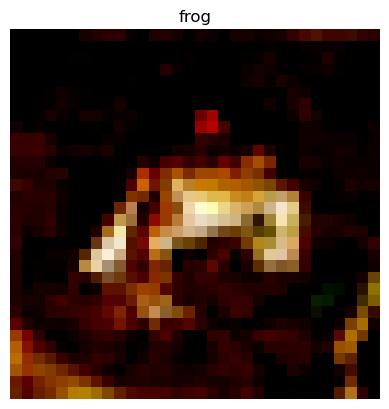

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


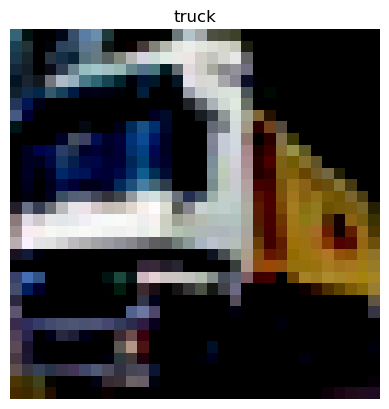

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


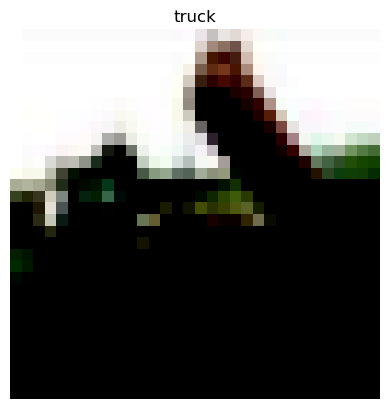

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


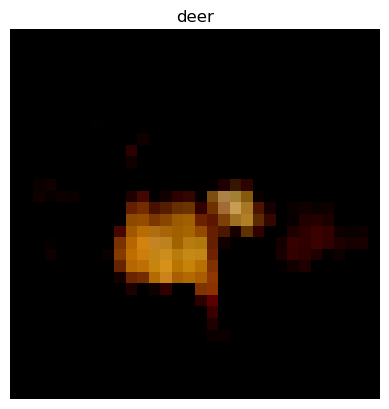

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


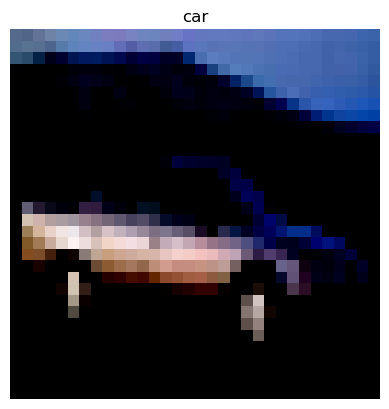

In [5]:
for i in range(5):
    show_tensor_image(trainset[i][0], label=classes[trainset[i][1]])

In [ ]:
class Model(nn.Module):
    def __init__(self, out_features, dropout_p=0.5):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=8, out_channels=60, kernel_size=5, stride=1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.Linear(in_features=32 * 5 * 5, out_features=1024),
            nn.Dropout1d(p=dropout_p),
            nn.ReLU(),

            nn.Linear(in_features=1024, out_features=512),
            nn.Dropout1d(p=dropout_p),
            nn.ReLU(),

            nn.Linear(in_features=512, out_features=out_features),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.mlp(x)

In [7]:
num_epochs = 10
dropout_prob = 0.5
learning_rate = 1e-3

In [8]:
net = Model(out_features=num_classes, dropout_p=dropout_prob).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
from torchviz import make_dot

Xb, yb = next(iter(trainloader))

y = net(Xb)

make_dot(y, params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [9]:
history_train = []
history_validation = []
for epoch in range(num_epochs):
    # train
    net.train()

    running_loss = 0.0

    for X_batch, Y_batch in trainloader:
        y_pred = net(X_batch.to(device))

        loss = criterion(y_pred, Y_batch.to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    # test
    net.eval()

    validation_loss = 0.0

    for X_batch, Y_batch in valloader:
        y_pred = net(X_batch.to(device))

        loss = criterion(y_pred, Y_batch.to(device))
        validation_loss += loss.item()


    print(f"epoch {epoch}: train loss: {running_loss}; validation loss: {validation_loss}")
    history_train.append(running_loss)
    history_validation.append(validation_loss)

epoch 0: train loss: 25900.59959793091; validation loss: 2877.154838323593
epoch 1: train loss: 25765.111526846886; validation loss: 2810.2467402219772
epoch 2: train loss: 25507.96894776821; validation loss: 2745.3896765708923
epoch 3: train loss: 25385.103143572807; validation loss: 2713.883710384369
epoch 4: train loss: 25317.291846990585; validation loss: 2679.8553006649017
epoch 5: train loss: 25239.653164625168; validation loss: 2649.2417660951614
epoch 6: train loss: 25215.44338798523; validation loss: 2635.448254466057
epoch 7: train loss: 25127.45009469986; validation loss: 2634.4114463329315
epoch 8: train loss: 25071.925734996796; validation loss: 2603.7912575006485
epoch 9: train loss: 25028.782889723778; validation loss: 2611.1977771520615


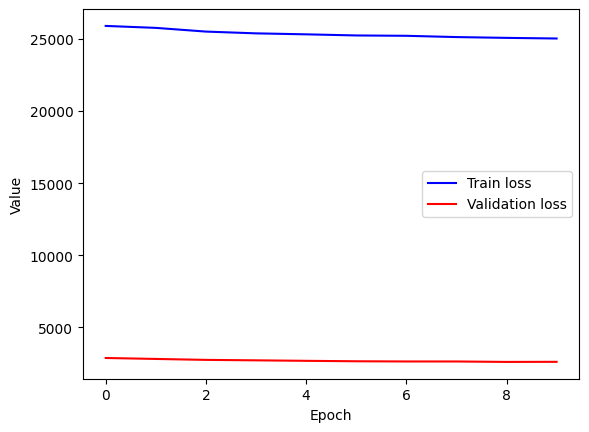

In [10]:
import matplotlib.pyplot as plt

def plot_functions(train_losses, val_losses):
    x = range(len(train_losses))

    plt.plot(x, train_losses, label="Train loss", color="blue")
    plt.plot(x, val_losses, label="Validation loss", color="red")

    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()

    plt.show()


plot_functions(history_train, history_validation)


In [11]:
def calculate_accuracy(net):
    correct = 0
    total = 0
    net.eval()

    with torch.no_grad():
        for X_test_batch, y_test_batch in testloader:
            outputs = net(X_test_batch.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += y_test_batch.size(0)
            correct += (predicted == y_test_batch.to(device)).sum().item()

    return correct / total


In [12]:
print(f"Accuracy of the network on the 10000 test images: {100 * calculate_accuracy(net)} %")

Accuracy of the network on the 10000 test images: 47.660000000000004 %


# Hyperparameter search

In [ ]:
class ModelBuilder(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [ ]:
def build_model(conv_2d_param, linear_param, dropout_prob):

    layers = []
    in_channels = 3
    size = 32

    for out_channels, kernel_size in conv_2d_param:
        layers += [
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        in_channels = out_channels
        size = size // 2

    layers += [nn.Flatten()]

    in_features = out_channels*size*size

    for out_features in linear_param:
        layers += [
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.Dropout1d(dropout_prob),
            nn.ReLU()
        ]
        in_features=out_features

    layers += [
        nn.Linear(in_features=512, out_features=out_features), 
        nn.Softmax(dim=1)
    ]

    return ModelBuilder(layers=layers)



In [21]:
def train_model_acc(conv_2d_param, linear_param, num_epochs, learning_rate, dropout_prob):
    net = build_model(conv_2d_param, linear_param, dropout_prob)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    net.train()

    for epoch in range(num_epochs):
        for X_batch, Y_batch in trainloader:
            y_pred = net(X_batch.to(device))

            loss = criterion(y_pred, Y_batch.to(device))
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

    return net, calculate_accuracy(net)


In [18]:
import optuna
from optuna.samplers import TPESampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00


In [ ]:
history = []

In [ ]:
def objective(trial):
    conv_2d_param = [
        (
            trial.suggest_int(f'conv_layer_channels_{i}', 8, 128),
            trial.suggest_int(f'conv_layer_kernel_size_{i}', low=3, high=5, step=2)
            ) for i in range(trial.suggest_int('n_conv_layers', 1, 3))
        ]
    linear_param = [
        trial.suggest_int(f'fc_layer_features_{i}', 64, 512, log=True) for i in range(trial.suggest_int('n_fc_layers', 1, 3))
        ]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_prob = trial.suggest_float('dropout_rate', 0.0, 0.5)
    num_epochs = trial.suggest_int('epochs', 4, 8)

    net, accuracy = train_model_acc(conv_2d_param, linear_param, num_epochs, learning_rate, dropout_prob)
    history.append(net)
    return accuracy

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=5, show_progress_bar=True)

[I 2024-11-01 18:48:20,099] A new study created in memory with name: no-name-f693a368-fe0f-4eae-a3a3-108b5ae60ad0


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-11-01 19:46:52,655] Trial 0 finished with value: 0.6506 and parameters: {'n_conv_layers': 1, 'conv_layer_channels_0': 82, 'conv_layer_kernel_size_0': 3, 'n_fc_layers': 3, 'fc_layer_features_0': 111, 'fc_layer_features_1': 131, 'fc_layer_features_2': 84, 'learning_rate': 0.0013854672192929673, 'dropout_rate': 0.09400771991450463, 'epochs': 10}. Best is trial 0 with value: 0.6506.
[I 2024-11-01 20:04:35,860] Trial 1 finished with value: 0.5458 and parameters: {'n_conv_layers': 1, 'conv_layer_channels_0': 18, 'conv_layer_kernel_size_0': 5, 'n_fc_layers': 1, 'fc_layer_features_0': 246, 'learning_rate': 0.001831448466532964, 'dropout_rate': 0.16368437344777964, 'epochs': 7}. Best is trial 0 with value: 0.6506.
[I 2024-11-01 20:26:50,694] Trial 2 finished with value: 0.3722 and parameters: {'n_conv_layers': 2, 'conv_layer_channels_0': 28, 'conv_layer_kernel_size_0': 3, 'conv_layer_channels_1': 21, 'conv_layer_kernel_size_1': 5, 'n_fc_layers': 3, 'fc_layer_features_0': 244, 'fc_layer_

In [20]:
best_params = study.best_params
print(best_params)

{'n_conv_layers': 2, 'conv_layer_channels_0': 71, 'conv_layer_kernel_size_0': 5, 'conv_layer_channels_1': 75, 'conv_layer_kernel_size_1': 3, 'n_fc_layers': 1, 'fc_layer_features_0': 76, 'learning_rate': 0.00011941964930588276, 'dropout_rate': 0.4675064239319546, 'epochs': 8}


In [ ]:
net, acc = train_model_acc(
    conv_2d_param=[(71,5), (75,3)],
    linear_param=[76],
    learning_rate=0.00011941964930588276,
    dropout_prob=0.4675064239319546,
    num_epochs=8
    )
print(f"Accuracy: {acc*100}%")

Accuracy: 66.99%


tensor([3, 1, 0, 9]) tensor([3, 1, 0, 9])


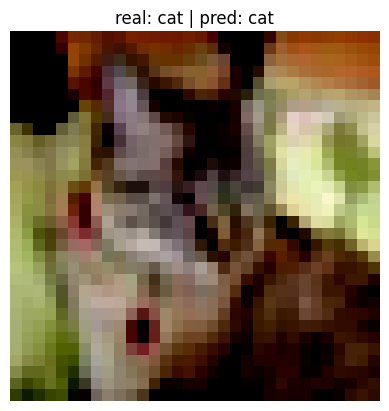

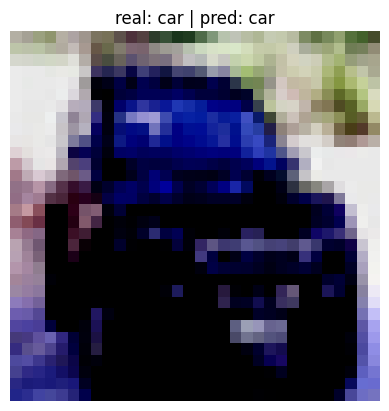

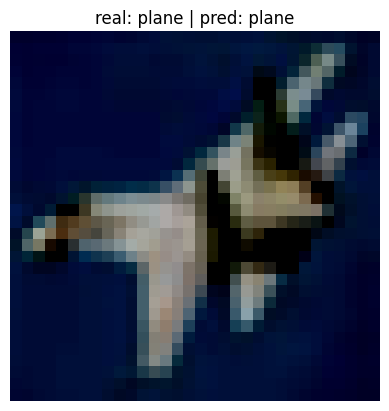

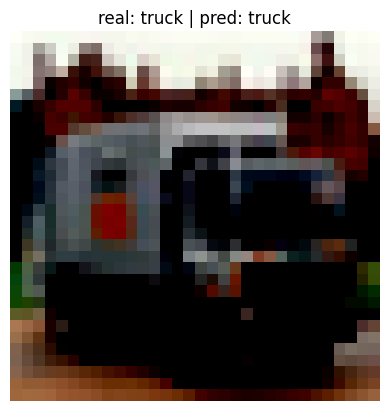

In [ ]:
i = (iter(testloader))
X_batch, y_batch = next(i)
X_batch, y_batch = next(i)
X_batch, y_batch = next(i)

y_pred = torch.argmax(net(X_batch), dim=1)
print(y_pred, y_batch)
for i in range(4):
    show_tensor_image(X_batch[i], label=f"real: {classes[y_batch[i]]} | pred: {classes[y_pred[i]]}")